In [ ]:
from google.colab import files
uploaded = files.upload()

Saving utils.py to utils.py


In [ ]:
!pip install soundfile
!pip install librosa==0.8.0
!pip install scipy==1.5.2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import librosa
import librosa.display as display
import librosa.feature
import soundfile as sf
import os
import sys
import torch
import cv2
import random
import math
from utils import generate_spec

     |████████████████████████████████| 25.9MB 1.6MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


# fdndlp implementation

Implementation https://github.com/helianvine/fdndlp

In [ ]:
!git clone https://github.com/helianvine/fdndlp.git

In [ ]:
sys.path.append('fdndlp/python/')
from wpe import WpeMethod

In [ ]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

## Qualitative Evaluation

In [ ]:
def evaluate_qualitative(audio_dirs, num_example, speech_rate=16000):
  """
  audio_dirs: list of directories containing reverberant waveforms and clean waveforms respectively
  num_example: example number in data
  speech_rate: sampling rate of speech data  
  """
  matplotlib.rc('xtick', labelsize=15) 
  matplotlib.rc('ytick', labelsize=15)
  matplotlib.rcParams.update({'font.size': 15})

  waves_target = torch.load(audio_dirs[0])
  waves_rev = torch.load(audio_dirs[1])
  
  rev_spec = generate_spec(waves_rev[num_example], speech_rate)
  orig_spec = generate_spec(waves_target[num_example], speech_rate)
  graph_spec(orig_spec)
  graph_spec(rev_spec)

  with HiddenPrints():
    wpe_model = WpeMethod(1, 1, 90)
    raw_drv_data = wpe_model.run_offline(np.reshape(np.array(waves_rev[num_example]), (1, -1)))
  raw_drv_data = np.reshape(raw_drv_data, (raw_drv_data.shape[1],))
  drv_data = raw_drv_data[0:len(waves_target[num_example])]

  drv_spec = generate_spec(drv_data, speech_rate)
  graph_spec(drv_spec)

In [ ]:
dir_list = ['/content/drive/My Drive/data_audio/non_norm_data/wavetarget.pth', '/content/drive/My Drive/data_audio/non_norm_data/waverev.pth']

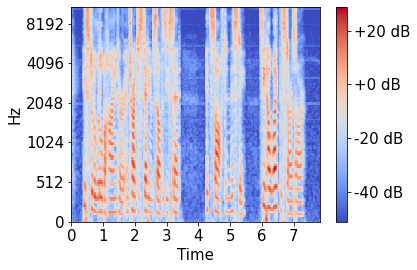

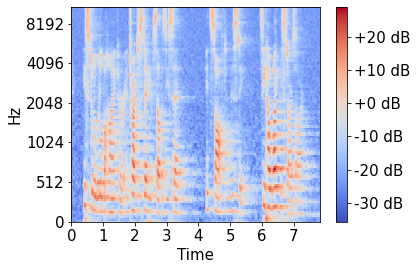

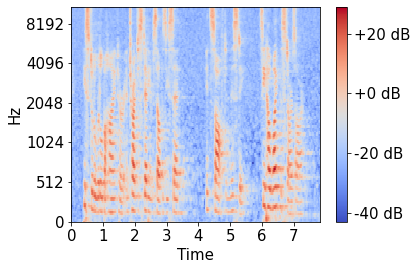

In [ ]:
evaluate_qualitative(dir_list, 100)

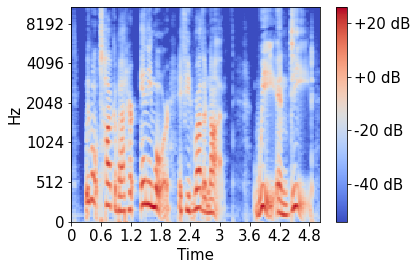

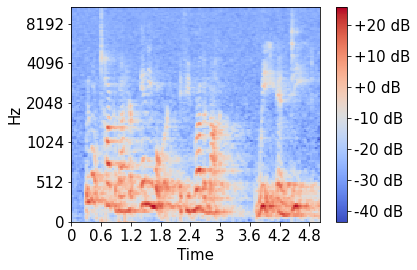

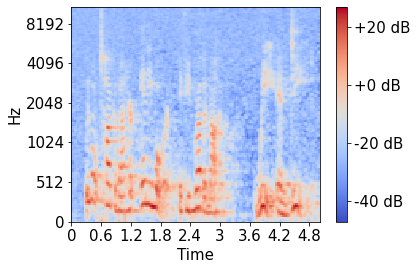

In [ ]:
evaluate_qualitative(dir_list, 300)

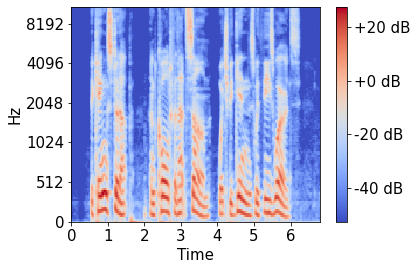

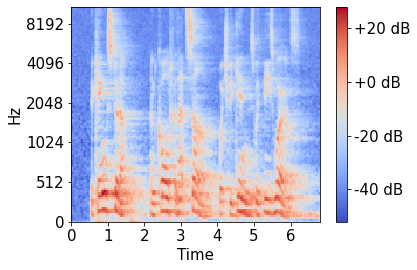

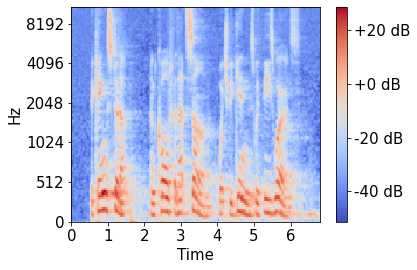

In [ ]:
evaluate_qualitative(dir_list, 400)

# Quantitative Evaluation

In [ ]:
!pip3 install https://github.com/schmiph2/pysepm/archive/master.zip

     - 2.1MB 1.8MB/s
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     | 276kB 29.0MB/s
     | 71kB 59.8MB/s
     \ 65.3MB 43kB/s
     |████████████████████████████████| 163kB 5.0MB/s 
  Created wheel for pysepm: filename=pysepm-0.1-cp37-none-any.whl size=24291 sha256=5ad8e26ae3c73a781f9e2edd49c1412d8c9d9431402fcb502128180fcbacf3e9
  Stored in directory: /tmp/pip-ephem-wheel-cache-kdrlf2lm/wheels/17/75/23/17712e0da834688ac430e0cf826dd1f7450d0b4873e0269f7c
Successfully built pysepm
  Created wheel for pesq: filename=pesq-0.0.2-cp37-cp37m-linux_x86_64.whl size=162259 sha256=ecc324b30786f03c9255e34e7a9dc75de86eefda735d2bf5b378c7f24e3cdc83
  Stored in directory: /tmp/pip-ephem-wheel-cache-kdrlf2lm/wheels/85/91/09/5ae7677a054a05d49111dc8f3b282e886b3852348384893a32
  Created wheel for SRMRpy: filename=SRMRpy-1.0-cp37-none-any.whl size=9397 sha256=3c40ce416440703c89661d6cfc1fafc4cbe146e04380a5894243872df3777154
 

In [ ]:
!pip install pystoi
!pip install pypesq
from pysepm import llr, cepstrum_distance, fwSNRseg, srmr 
from pystoi import stoi
from pypesq import pesq

  Created wheel for pypesq: filename=pypesq-1.2.4-cp37-cp37m-linux_x86_64.whl size=84234 sha256=81ca44e68f6f15c9361d09b84807d924713003433120b43773f2fe0afec47ec7
  Stored in directory: /root/.cache/pip/wheels/c9/29/a6/ed19583426cffac50b3e75160f894120a49f9bafa585a2edbe
Successfully built pypesq


In [ ]:
def evaluate_wpe(lower_bound, upper_bound, path_vector, initial = True):
  """
  lower_bound: first example to be considered
  upper_bound: last example to be considered
  path_vector: list of directories -> dir to save results, dir where reverberant waveforms are
                                     dir where clean waveforms are
  initial: True if is the first time executing, False if is not the first time
           if is False the new results are added to the existing results
  """

  path = path_vector[0]
  path_rev = path_vector[1]
  path_targets = path_vector[2]
  
  if (initial):
    reverb_pesq_list = []
    reverb_stoi_list = []
    reverb_llr_list = []
    reverb_cd_list = []
    reverb_fwSNRseg_list = []
    reverb_srmr_list = []

    dereverb_pesq_list = []
    dereverb_stoi_list = []
    dereverb_llr_list = []
    dereverb_cd_list = []
    dereverb_fwSNRseg_list = []
    dereverb_srmr_list = []
  
  else:
    reverb_pesq_list = torch.load(path + 'reverb_pesq_wpe.pth')
    reverb_stoi_list = torch.load(path + 'reverb_stoi_wpe.pth')
    reverb_llr_list = torch.load(path + 'reverb_llr_wpe.pth')
    reverb_cd_list = torch.load(path + 'reverb_cd_wpe.pth')
    reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_wpe.pth')
    reverb_srmr_list = torch.load(path + 'reverb_srmr_wpe.pth')

    dereverb_pesq_list = torch.load(path + 'dereverb_pesq_wpe.pth')
    dereverb_stoi_list = torch.load(path + 'dereverb_stoi_wpe.pth')
    dereverb_llr_list = torch.load(path + 'dereverb_llr_wpe.pth')
    dereverb_cd_list = torch.load(path + 'dereverb_cd_wpe.pth')
    dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_wpe.pth')
    dereverb_srmr_list = torch.load(path + 'dereverb_srmr_wpe.pth')

  
  wave_rev = torch.load(path_rev)
  wave_targets = torch.load(path_targets)

  speech_rate = 16000

  for i in range(lower_bound, upper_bound):
    print("Processing audio file n°" + str(i+1))
    
    try:
      
      with HiddenPrints():
        wpe_model = WpeMethod(1, 1, 90)
        raw_drv_data = wpe_model.run_offline(np.reshape(np.array(wave_rev[i]), (1, -1)))
      
      raw_drv_data = np.reshape(raw_drv_data, (raw_drv_data.shape[1],))
      drv_data = raw_drv_data[0:len(wave_targets[i])]

      speech_audio = wave_targets[i]
      speech_rev = wave_rev[i]

      pesq_metric_rev = pesq(speech_audio, speech_rev, fs = speech_rate)
      stoi_metric_rev = stoi(speech_audio, speech_rev, speech_rate)
      llr_metric_rev = llr(speech_audio, speech_rev, speech_rate)
      cd_metric_rev = cepstrum_distance(speech_audio, speech_rev, speech_rate)
      fwSNRseg_metric_rev = fwSNRseg(speech_audio, speech_rev, speech_rate)
      srmr_metric_rev = srmr(wave_rev[i], speech_rate)

      pesq_metric_recon = pesq(speech_audio, drv_data, fs = speech_rate)
      stoi_metric_recon = stoi(speech_audio, drv_data, speech_rate)
      llr_metric_recon = llr(speech_audio, drv_data, speech_rate)
      cd_metric_recon = cepstrum_distance(speech_audio, drv_data, speech_rate)
      fwSNRseg_metric_recon = fwSNRseg(speech_audio, drv_data, speech_rate)
      srmr_metric_recon = srmr(raw_drv_data, speech_rate)

      reverb_pesq_list.append(pesq_metric_rev)
      reverb_stoi_list.append(stoi_metric_rev)
      reverb_llr_list.append(llr_metric_rev)
      reverb_cd_list.append(cd_metric_rev)
      reverb_fwSNRseg_list.append(fwSNRseg_metric_rev)
      reverb_srmr_list.append(srmr_metric_rev)

      dereverb_pesq_list.append(pesq_metric_recon)
      dereverb_stoi_list.append(stoi_metric_recon)
      dereverb_llr_list.append(llr_metric_recon)
      dereverb_cd_list.append(cd_metric_recon)
      dereverb_fwSNRseg_list.append(fwSNRseg_metric_recon)
      dereverb_srmr_list.append(srmr_metric_recon)

      print('PESQ reverberated signal: {:.3f} || PESQ dereverberated signal: {:.3f}'.format(pesq_metric_rev, pesq_metric_recon))
      print('STOI reverberated signal: {:.3f} || STOI dereverberated signal: {:.3f}'.format(stoi_metric_rev, stoi_metric_recon))
      print('LLR reverberated signal: {:.3f} || LLR dereverberated signal: {:.3f}'.format(llr_metric_rev, llr_metric_recon))
      print('CD reverberated signal: {:.3f} || CD dereverberated signal: {:.3f}'.format(cd_metric_rev, cd_metric_recon))
      print('fwSNRseg reverberated signal: {:.3f} || fwSNRseg dereverberated signal: {:.3f}'.format(fwSNRseg_metric_rev, fwSNRseg_metric_recon))
      print('SRMR reverberated signal: {:.3f} || SRMR dereverberated signal: {:.3f}'.format(srmr_metric_rev, srmr_metric_recon))
      print('\n')  
      
    
    except (librosa.feature.inverse.ParameterError, np.linalg.LinAlgError):
      pass

  
    if ((i+1)%10 == 0):
      torch.save(reverb_pesq_list, path + 'reverb_pesq_wpe.pth')
      torch.save(reverb_stoi_list, path + 'reverb_stoi_wpe.pth')
      torch.save(reverb_llr_list, path + 'reverb_llr_wpe.pth')
      torch.save(reverb_cd_list, path + 'reverb_cd_wpe.pth')
      torch.save(reverb_fwSNRseg_list, path + 'reverb_fwSNRseg_wpe.pth')
      torch.save(reverb_srmr_list, path + 'reverb_srmr_wpe.pth')

      torch.save(dereverb_pesq_list, path + 'dereverb_pesq_wpe.pth')
      torch.save(dereverb_stoi_list, path + 'dereverb_stoi_wpe.pth')
      torch.save(dereverb_llr_list, path + 'dereverb_llr_wpe.pth')
      torch.save(dereverb_cd_list, path + 'dereverb_cd_wpe.pth')
      torch.save(dereverb_fwSNRseg_list, path + 'dereverb_fwSNRseg_wpe.pth')
      torch.save(dereverb_srmr_list, path + 'dereverb_srmr_wpe.pth')
      print('Saved')


## Simulated room 1

In [ ]:
paths = ['/content/drive/My Drive/metrics_audio/', '/content/drive/My Drive/data_audio/non_norm_data/waverev.pth', 
         '/content/drive/My Drive/data_audio/non_norm_data/wavetarget.pth']
evaluate_wpe(0, 500, paths)

Processing audio file n°1
PESQ reverberated signal: 2.241 || PESQ dereverberated signal: 2.599
STOI reverberated signal: 0.840 || STOI dereverberated signal: 0.892
LLR reverberated signal: 0.341 || LLR dereverberated signal: 0.240
CD reverberated signal: 3.498 || CD dereverberated signal: 2.775
fwSNRseg reverberated signal: 9.593 || fwSNRseg dereverberated signal: 11.849
SRMR reverberated signal: 2.961 || SRMR dereverberated signal: 4.118


Processing audio file n°2
PESQ reverberated signal: 2.171 || PESQ dereverberated signal: 2.497
STOI reverberated signal: 0.808 || STOI dereverberated signal: 0.863
LLR reverberated signal: 0.377 || LLR dereverberated signal: 0.259
CD reverberated signal: 3.738 || CD dereverberated signal: 2.959
fwSNRseg reverberated signal: 8.344 || fwSNRseg dereverberated signal: 10.490
SRMR reverberated signal: 3.543 || SRMR dereverberated signal: 4.816


Processing audio file n°3
PESQ reverberated signal: 2.146 || PESQ dereverberated signal: 2.515
STOI reverberat

In [ ]:
path = '/content/drive/My Drive/metrics_audio/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_wpe.pth')
reverb_stoi_list = torch.load(path + 'reverb_stoi_wpe.pth')
reverb_llr_list = torch.load(path + 'reverb_llr_wpe.pth')
reverb_cd_list = torch.load(path + 'reverb_cd_wpe.pth')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_wpe.pth')
reverb_srmr_list = torch.load(path + 'reverb_srmr_wpe.pth')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_wpe.pth')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_wpe.pth')
dereverb_llr_list = torch.load(path + 'dereverb_llr_wpe.pth')
dereverb_cd_list = torch.load(path + 'dereverb_cd_wpe.pth')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_wpe.pth')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_wpe.pth')


print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 2.11
STOI: 0.84
LLR: 0.81
CD: 5.39
fwSNRseg: 7.69
SRMR: 3.17

Dereverberated signal:
PESQ: 2.31
STOI: 0.86
LLR: 0.82
CD: 5.26
fwSNRseg: 8.86
SRMR: 4.55


## Simulated Room 2

In [ ]:
paths = ['/content/drive/My Drive/metrics_audio/room2/', '/content/drive/My Drive/data_audio/non_norm_data/waverev_2.pth', 
         '/content/drive/My Drive/data_audio/non_norm_data/wavetarget_2.pth']
evaluate_wpe(0, 500, paths)

Processing audio file n°1
PESQ reverberated signal: 2.296 || PESQ dereverberated signal: 2.400
STOI reverberated signal: 0.614 || STOI dereverberated signal: 0.640
LLR reverberated signal: 1.095 || LLR dereverberated signal: 1.100
CD reverberated signal: 6.273 || CD dereverberated signal: 6.291
fwSNRseg reverberated signal: 7.129 || fwSNRseg dereverberated signal: 7.437
SRMR reverberated signal: 2.991 || SRMR dereverberated signal: 3.425


Processing audio file n°2
PESQ reverberated signal: 2.240 || PESQ dereverberated signal: 2.314
STOI reverberated signal: 0.670 || STOI dereverberated signal: 0.686
LLR reverberated signal: 1.256 || LLR dereverberated signal: 1.247
CD reverberated signal: 6.942 || CD dereverberated signal: 6.941
fwSNRseg reverberated signal: 6.317 || fwSNRseg dereverberated signal: 6.463
SRMR reverberated signal: 2.799 || SRMR dereverberated signal: 3.295


Processing audio file n°3
PESQ reverberated signal: 2.191 || PESQ dereverberated signal: 2.285
STOI reverberated

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room2/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_wpe.pth')
reverb_stoi_list = torch.load(path + 'reverb_stoi_wpe.pth')
reverb_llr_list = torch.load(path + 'reverb_llr_wpe.pth')
reverb_cd_list = torch.load(path + 'reverb_cd_wpe.pth')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_wpe.pth')
reverb_srmr_list = torch.load(path + 'reverb_srmr_wpe.pth')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_wpe.pth')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_wpe.pth')
dereverb_llr_list = torch.load(path + 'dereverb_llr_wpe.pth')
dereverb_cd_list = torch.load(path + 'dereverb_cd_wpe.pth')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_wpe.pth')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_wpe.pth')


print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 2.15
STOI: 0.67
LLR: 0.97
CD: 5.71
fwSNRseg: 6.58
SRMR: 4.49

Dereverberated signal:
PESQ: 2.24
STOI: 0.67
LLR: 1.00
CD: 5.83
fwSNRseg: 6.60
SRMR: 5.34


## Room Simulated 3

In [ ]:
paths = ['/content/drive/My Drive/metrics_audio/room3/', '/content/drive/My Drive/data_audio/non_norm_data/waverev_3.pth', 
         '/content/drive/My Drive/data_audio/non_norm_data/wavetarget_3.pth']
evaluate_wpe(0, 500, paths)

Processing audio file n°1
PESQ reverberated signal: 2.574 || PESQ dereverberated signal: 2.699
STOI reverberated signal: 0.762 || STOI dereverberated signal: 0.780
LLR reverberated signal: 1.021 || LLR dereverberated signal: 1.024
CD reverberated signal: 6.051 || CD dereverberated signal: 6.096
fwSNRseg reverberated signal: 9.153 || fwSNRseg dereverberated signal: 9.512
SRMR reverberated signal: 3.481 || SRMR dereverberated signal: 3.970


Processing audio file n°2
PESQ reverberated signal: 2.540 || PESQ dereverberated signal: 2.670
STOI reverberated signal: 0.799 || STOI dereverberated signal: 0.812
LLR reverberated signal: 1.174 || LLR dereverberated signal: 1.173
CD reverberated signal: 6.630 || CD dereverberated signal: 6.652
fwSNRseg reverberated signal: 7.911 || fwSNRseg dereverberated signal: 8.333
SRMR reverberated signal: 3.663 || SRMR dereverberated signal: 4.139


Processing audio file n°3
PESQ reverberated signal: 2.588 || PESQ dereverberated signal: 2.741
STOI reverberated

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room3/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_wpe.pth')
reverb_stoi_list = torch.load(path + 'reverb_stoi_wpe.pth')
reverb_llr_list = torch.load(path + 'reverb_llr_wpe.pth')
reverb_cd_list = torch.load(path + 'reverb_cd_wpe.pth')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_wpe.pth')
reverb_srmr_list = torch.load(path + 'reverb_srmr_wpe.pth')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_wpe.pth')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_wpe.pth')
dereverb_llr_list = torch.load(path + 'dereverb_llr_wpe.pth')
dereverb_cd_list = torch.load(path + 'dereverb_cd_wpe.pth')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_wpe.pth')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_wpe.pth')


print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 2.57
STOI: 0.83
LLR: 0.85
CD: 5.25
fwSNRseg: 8.68
SRMR: 5.21

Dereverberated signal:
PESQ: 2.71
STOI: 0.83
LLR: 0.90
CD: 5.44
fwSNRseg: 8.57
SRMR: 6.03


## Room Simulated 4

In [ ]:
paths = ['/content/drive/My Drive/metrics_audio/room4/', '/content/drive/My Drive/data_audio/non_norm_data/waverev_4.pth', 
         '/content/drive/My Drive/data_audio/non_norm_data/wavetarget_4.pth']
evaluate_wpe(0, 500, paths)

Processing audio file n°1
PESQ reverberated signal: 2.372 || PESQ dereverberated signal: 2.625
STOI reverberated signal: 0.832 || STOI dereverberated signal: 0.891
LLR reverberated signal: 0.413 || LLR dereverberated signal: 0.348
CD reverberated signal: 3.930 || CD dereverberated signal: 3.417
fwSNRseg reverberated signal: 8.718 || fwSNRseg dereverberated signal: 10.577
SRMR reverberated signal: 2.446 || SRMR dereverberated signal: 3.569


Processing audio file n°2
PESQ reverberated signal: 2.439 || PESQ dereverberated signal: 2.622
STOI reverberated signal: 0.852 || STOI dereverberated signal: 0.905
LLR reverberated signal: 0.530 || LLR dereverberated signal: 0.463
CD reverberated signal: 4.465 || CD dereverberated signal: 3.947
fwSNRseg reverberated signal: 9.210 || fwSNRseg dereverberated signal: 10.671
SRMR reverberated signal: 2.231 || SRMR dereverberated signal: 3.157


Processing audio file n°3
PESQ reverberated signal: 2.346 || PESQ dereverberated signal: 2.624
STOI reverberat

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room4/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_wpe.pth')
reverb_stoi_list = torch.load(path + 'reverb_stoi_wpe.pth')
reverb_llr_list = torch.load(path + 'reverb_llr_wpe.pth')
reverb_cd_list = torch.load(path + 'reverb_cd_wpe.pth')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_wpe.pth')
reverb_srmr_list = torch.load(path + 'reverb_srmr_wpe.pth')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_wpe.pth')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_wpe.pth')
dereverb_llr_list = torch.load(path + 'dereverb_llr_wpe.pth')
dereverb_cd_list = torch.load(path + 'dereverb_cd_wpe.pth')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_wpe.pth')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_wpe.pth')


print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 2.17
STOI: 0.85
LLR: 0.59
CD: 4.69
fwSNRseg: 8.12
SRMR: 3.15

Dereverberated signal:
PESQ: 2.43
STOI: 0.88
LLR: 0.54
CD: 4.30
fwSNRseg: 9.66
SRMR: 4.47


## Simulated Room 5

In [ ]:
paths = ['/content/drive/My Drive/metrics_audio/room5/', '/content/drive/My Drive/data_audio/non_norm_data/waverev_5.pth', 
         '/content/drive/My Drive/data_audio/non_norm_data/wavetarget_5.pth']
evaluate_wpe(0, 500, paths)

Processing audio file n°1
PESQ reverberated signal: 1.951 || PESQ dereverberated signal: 2.058
STOI reverberated signal: 0.760 || STOI dereverberated signal: 0.795
LLR reverberated signal: 1.263 || LLR dereverberated signal: 1.286
CD reverberated signal: 6.593 || CD dereverberated signal: 6.675
fwSNRseg reverberated signal: 5.571 || fwSNRseg dereverberated signal: 6.065
SRMR reverberated signal: 3.246 || SRMR dereverberated signal: 4.189


Processing audio file n°2
PESQ reverberated signal: 1.884 || PESQ dereverberated signal: 1.994
STOI reverberated signal: 0.771 || STOI dereverberated signal: 0.804
LLR reverberated signal: 1.256 || LLR dereverberated signal: 1.283
CD reverberated signal: 6.778 || CD dereverberated signal: 6.983
fwSNRseg reverberated signal: 6.492 || fwSNRseg dereverberated signal: 6.989
SRMR reverberated signal: 3.948 || SRMR dereverberated signal: 5.220


Processing audio file n°3
PESQ reverberated signal: 2.040 || PESQ dereverberated signal: 2.212
STOI reverberated

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room5/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_wpe.pth')
reverb_stoi_list = torch.load(path + 'reverb_stoi_wpe.pth')
reverb_llr_list = torch.load(path + 'reverb_llr_wpe.pth')
reverb_cd_list = torch.load(path + 'reverb_cd_wpe.pth')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_wpe.pth')
reverb_srmr_list = torch.load(path + 'reverb_srmr_wpe.pth')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_wpe.pth')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_wpe.pth')
dereverb_llr_list = torch.load(path + 'dereverb_llr_wpe.pth')
dereverb_cd_list = torch.load(path + 'dereverb_cd_wpe.pth')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_wpe.pth')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_wpe.pth')


print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 1.97
STOI: 0.80
LLR: 1.36
CD: 7.30
fwSNRseg: 6.38
SRMR: 3.08

Dereverberated signal:
PESQ: 2.09
STOI: 0.82
LLR: 1.39
CD: 7.45
fwSNRseg: 6.96
SRMR: 4.25


In [ ]:
def evaluate_realdata(lower_bound, upper_bound, path_vector, initial = True):
  """
  Evaluate for real data (not simulared with RIRs)
  lower_bound: first example to be considered
  upper_bound: last example to be considered
  path_vector: list of directories -> dir to save results, dir where reverberant waveforms are
                                     dir where clean waveforms are
  initial: True if is the first time executing, False if is not the first time
           if is False the new results are added to the existing results
  """

  path = path_vector[0]
  path_rev = path_vector[1]
  
  if (initial):
    reverb_srmr_list = []
    dereverb_srmr_list = []
  
  else:

    reverb_srmr_list = torch.load(path + 'reverb_srmr_wpe.pth')
    dereverb_srmr_list = torch.load(path + 'dereverb_srmr_wpe.pth')

  
  wave_rev = torch.load(path_rev)
  speech_rate = 16000

  for i in range(lower_bound, upper_bound):
    print("Processing audio file n°" + str(i+1))
    
    try:
    
      wpe = WpeMethod(1, 1, 90)
      raw_drv_data = wpe.run_offline(np.reshape(np.array(wave_rev[i]), (1, -1)))
      raw_drv_data = np.reshape(raw_drv_data, (raw_drv_data.shape[1],))
      srmr_metric_rev = srmr(wave_rev[i], speech_rate)
      srmr_metric_recon = srmr(raw_drv_data, speech_rate)

      reverb_srmr_list.append(srmr_metric_rev)
      dereverb_srmr_list.append(srmr_metric_recon)

      print('SRMR reverberated signal: {:.3f} || SRMR dereverberated signal: {:.3f}'.format(srmr_metric_rev, srmr_metric_recon))
      print('\n')  
      
    
    except (librosa.feature.inverse.ParameterError, np.linalg.LinAlgError):
      pass

  
    if ((i+1)%10 == 0):

      torch.save(reverb_srmr_list, path + 'reverb_srmr_wpe.pth')
      torch.save(dereverb_srmr_list, path + 'dereverb_srmr_wpe.pth')
      print('Saved')

## Real far data

In [ ]:
paths = ['/content/drive/My Drive/real_data/far_data/', '/content/drive/My Drive/real_data/waves2.pth']
evaluate_realdata(0, 500, paths, initial = True)

Processing audio file n°1
SRMR reverberated signal: 3.544 || SRMR dereverberated signal: 4.784


Processing audio file n°2
SRMR reverberated signal: 5.083 || SRMR dereverberated signal: 5.041


Processing audio file n°3
SRMR reverberated signal: 4.067 || SRMR dereverberated signal: 4.900


Processing audio file n°4
SRMR reverberated signal: 3.647 || SRMR dereverberated signal: 5.027


Processing audio file n°5
SRMR reverberated signal: 5.406 || SRMR dereverberated signal: 3.010


Processing audio file n°6
SRMR reverberated signal: 3.478 || SRMR dereverberated signal: 4.145


Processing audio file n°7
SRMR reverberated signal: 5.542 || SRMR dereverberated signal: 9.419


Processing audio file n°8
SRMR reverberated signal: 2.970 || SRMR dereverberated signal: 3.756


Processing audio file n°9
SRMR reverberated signal: 7.028 || SRMR dereverberated signal: 8.755


Processing audio file n°10
SRMR reverberated signal: 5.625 || SRMR dereverberated signal: 6.767


Saved
Processing audio file n

In [ ]:
path = '/content/drive/My Drive/real_data/far_data/'
reverb_srmr_list = torch.load(path + 'reverb_srmr_wpe.pth')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_wpe.pth')

print('Results: \n')
print('Reverberant signal:')
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
SRMR: 4.36

Dereverberated signal:
SRMR: 5.43


## Real near data

In [ ]:
paths = ['/content/drive/My Drive/real_data/near_data/', '/content/drive/My Drive/real_data/waves1.pth']
evaluate_realdata(0, 500, paths, initial = True)

Processing audio file n°1
SRMR reverberated signal: 2.644 || SRMR dereverberated signal: 3.023


Processing audio file n°2
SRMR reverberated signal: 2.455 || SRMR dereverberated signal: 2.952


Processing audio file n°3
SRMR reverberated signal: 3.125 || SRMR dereverberated signal: 3.668


Processing audio file n°4
SRMR reverberated signal: 2.727 || SRMR dereverberated signal: 3.179


Processing audio file n°5
SRMR reverberated signal: 2.833 || SRMR dereverberated signal: 3.509


Processing audio file n°6
SRMR reverberated signal: 3.089 || SRMR dereverberated signal: 2.454


Processing audio file n°7
SRMR reverberated signal: 2.542 || SRMR dereverberated signal: 2.882


Processing audio file n°8
SRMR reverberated signal: 2.694 || SRMR dereverberated signal: 2.270


Processing audio file n°9
SRMR reverberated signal: 2.502 || SRMR dereverberated signal: 3.038


Processing audio file n°10
SRMR reverberated signal: 4.001 || SRMR dereverberated signal: 2.994


Saved
Processing audio file n

In [ ]:
path = '/content/drive/My Drive/real_data/near_data/'
reverb_srmr_list = torch.load(path + 'reverb_srmr_wpe.pth')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_wpe.pth')

print('Results: \n')
print('Reverberant signal:')
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
SRMR: 3.99

Dereverberated signal:
SRMR: 4.95
